In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.svm import SVC
bank_data = pd.read_csv("BankChurners.csv").drop(columns = ['CLIENTNUM'])

#Transfer card category to integers, because there is a hierarical relationship
card_cate_map = {'Blue': 0, 'Silver': 1, 'Gold':2, 'Platinum': 3}
for i in range(len(bank_data['Card_Category'])):
    for j in card_cate_map:
        if bank_data['Card_Category'][i] == j:
            bank_data.at[i, 'Card_Category'] = card_cate_map[j]       

#Transfer education category to integers, because there is a hierarical relationship
education_cate_map = {'Unknown':-1,'Uneducated':0,'High School':1,'College':2,'Graduate':3,'Post-Graduate':4, 'Doctorate':5 }
for i in range(len(bank_data['Education_Level'])):
    for j in education_cate_map:
        if bank_data['Education_Level'][i] == j:
            bank_data.at[i, 'Education_Level'] = education_cate_map[j]

income_cate_map = {'Unknown': -1, 'Less than $40K': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K':3, '$120K +': 4}
for i in range(len(bank_data['Income_Category'])):
    for j in income_cate_map:
        if bank_data['Income_Category'][i] == j:
            bank_data.at[i, 'Income_Category'] = income_cate_map[j]
            
attrition_flag_map = {'Existing Customer': 0, 'Attrited Customer': 1}
for i in range(len(bank_data['Attrition_Flag'])):
    for j in attrition_flag_map:
        if bank_data['Attrition_Flag'][i] == j:
            bank_data.at[i, 'Attrition_Flag'] = attrition_flag_map[j]
            
data = pd.get_dummies(bank_data, columns = ['Gender','Marital_Status'])
data = data.dropna()
data

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,0,45,3,1,2,0,39,5,1,3,...,1144,42,1.625,0.061,0,1,0,1,0,0
1,0,49,5,3,0,0,44,6,1,2,...,1291,33,3.714,0.105,1,0,0,0,1,0
2,0,51,3,3,3,0,36,4,1,0,...,1887,20,2.333,0.000,0,1,0,1,0,0
3,0,40,4,1,0,0,34,3,4,1,...,1171,20,2.333,0.760,1,0,0,0,0,1
4,0,40,3,0,2,0,21,5,1,0,...,816,28,2.500,0.000,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,2,3,1,0,40,3,2,3,...,15476,117,0.857,0.462,0,1,0,0,1,0
10123,1,41,2,-1,1,0,25,4,2,3,...,8764,69,0.683,0.511,0,1,1,0,0,0
10124,1,44,1,1,0,0,36,5,3,4,...,10291,60,0.818,0.000,1,0,0,1,0,0
10125,1,30,2,3,1,0,36,4,3,3,...,8395,62,0.722,0.000,0,1,0,0,0,1


In [2]:
data = data.to_numpy()
data

array([[0, 45, 3, ..., 1, 0, 0],
       [0, 49, 5, ..., 0, 1, 0],
       [0, 51, 3, ..., 1, 0, 0],
       ...,
       [1, 44, 1, ..., 1, 0, 0],
       [1, 30, 2, ..., 0, 0, 1],
       [1, 43, 2, ..., 1, 0, 0]], dtype=object)

In [3]:
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import LabelEncoder

X = data[:, 1:]
y = data[:, 0]

# Use LabelEncoder to transform target values into integers.
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(type_of_target(y))
print(y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

binary
[0 0 0 ... 1 1 1]


In [4]:
# Preprocess the data with the StandardScalar
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

# Removes highly correlated data
X = pd.DataFrame(X)
cor_matrix = X.corr().abs()
# Select upper triangle of correlation matrix
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print("There are " + str(len(to_drop)) + " columns to be dropped")
X = X.drop(X.columns[to_drop], axis = 1)

There are 2 columns to be dropped


The model running is: DecisionTreeClassifier()


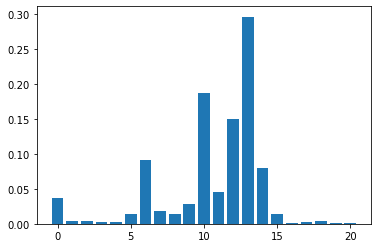

{'Decision Tree Feature': {'Feature 13': 0.29653220896570354}}
The mean accuracy of  Decision Tree  is:  0.9369020023643255  and the standard deviation is:  0.0036755217346149545
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8500
           1       0.81      0.82      0.81      1627

    accuracy                           0.94     10127
   macro avg       0.89      0.89      0.89     10127
weighted avg       0.94      0.94      0.94     10127

                 Predicted Negative  Predicted Positive
Actual Negative                8180                 320
Actual Positive                 295                1332

The FN is  295
The tn is  8180
The tp is  1332
The fp is  320

The precision is:  0.8062953995157385
The recall is:  0.8186846957590658
The f1 score is:  0.8124428179322963
Area under the Receiver Operating Characteristic curve: 0.8905188184677681


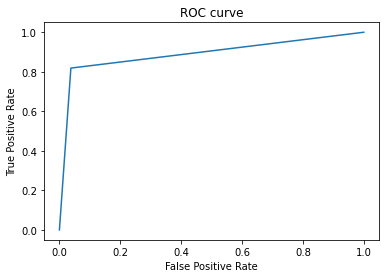


The model running is: SVC(C=2.0, kernel='linear')
{'Decision Tree Feature': {'Feature 13': 0.29653220896570354}}
The mean accuracy of  SVM Linear  is:  0.9059943694928887  and the standard deviation is:  0.005581897114613247
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      8500
           1       0.78      0.57      0.66      1627

    accuracy                           0.91     10127
   macro avg       0.85      0.77      0.80     10127
weighted avg       0.90      0.91      0.90     10127

                 Predicted Negative  Predicted Positive
Actual Negative                8237                 263
Actual Positive                 694                 933

The FN is  694
The tn is  8237
The tp is  933
The fp is  263

The precision is:  0.7801003344481605
The recall is:  0.5734480639213276
The f1 score is:  0.6609989373007439
Area under the Receiver Operating Characteristic curve: 0.7712534437253697


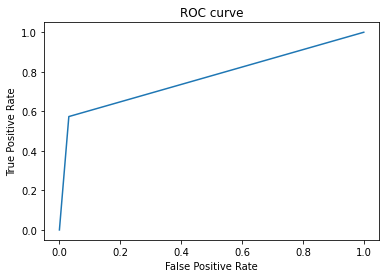


The model running is: BaggingClassifier(n_estimators=200, oob_score=True)
{'Decision Tree Feature': {'Feature 13': 0.29653220896570354}}
The mean accuracy of  BaggingClassifier  is:  0.9605999536884697  and the standard deviation is:  0.0025319625721567578
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      8500
           1       0.90      0.86      0.88      1627

    accuracy                           0.96     10127
   macro avg       0.94      0.92      0.93     10127
weighted avg       0.96      0.96      0.96     10127

                 Predicted Negative  Predicted Positive
Actual Negative                8347                 153
Actual Positive                 230                1397

The FN is  230
The tn is  8347
The tp is  1397
The fp is  153

The precision is:  0.9012903225806451
The recall is:  0.8586355255070682
The f1 score is:  0.8794460182562165
Area under the Receiver Operating Characteristic curve: 0.920317762753534

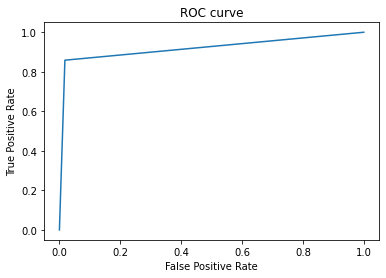


The model running is: RandomForestClassifier(max_features='sqrt', n_estimators=200, oob_score=True)


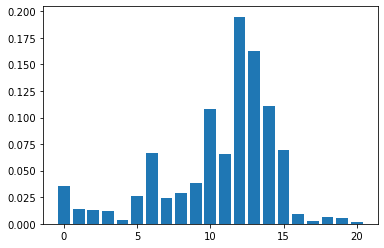

{'Decision Tree Feature': {'Feature 13': 0.29653220896570354}, 'Random Forest Feature': {'Feature 12': 0.19481709309195538}}
The mean accuracy of  RandomForest  is:  0.9610943658367154  and the standard deviation is:  0.0020524088474516275
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8500
           1       0.93      0.82      0.88      1627

    accuracy                           0.96     10127
   macro avg       0.95      0.91      0.93     10127
weighted avg       0.96      0.96      0.96     10127

                 Predicted Negative  Predicted Positive
Actual Negative                8406                  94
Actual Positive                 287                1340

The FN is  287
The tn is  8406
The tp is  1340
The fp is  94

The precision is:  0.9344490934449093
The recall is:  0.8236017209588199
The f1 score is:  0.875530872263966
Area under the Receiver Operating Characteristic curve: 0.906271448714704


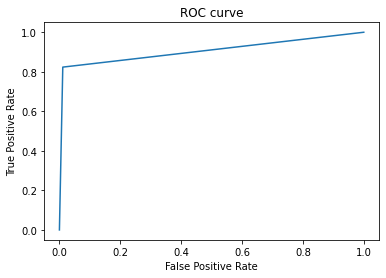


The model running is: AdaBoostClassifier(learning_rate=0.3, n_estimators=200)


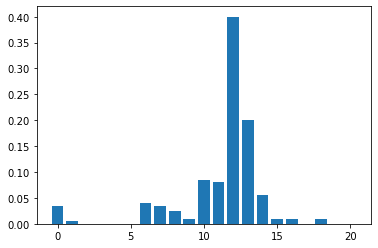

{'Decision Tree Feature': {'Feature 13': 0.29653220896570354}, 'Random Forest Feature': {'Feature 12': 0.19481709309195538}, 'AdaBoost Feature': {'Feature 12': 0.4}}
The mean accuracy of  Adaboost  is:  0.9600078485856702  and the standard deviation is:  0.0028794651946061865
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8500
           1       0.92      0.84      0.87      1627

    accuracy                           0.96     10127
   macro avg       0.94      0.91      0.93     10127
weighted avg       0.96      0.96      0.96     10127

                 Predicted Negative  Predicted Positive
Actual Negative                8375                 125
Actual Positive                 267                1360

The FN is  267
The tn is  8375
The tp is  1360
The fp is  125

The precision is:  0.9158249158249159
The recall is:  0.8358942839582053
The f1 score is:  0.8740359897172237
Area under the Receiver Operating Characteristic curve

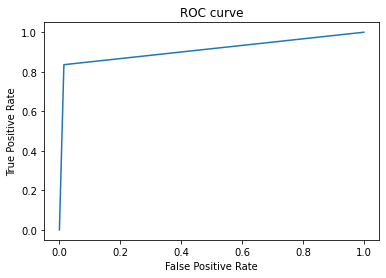

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot
from sklearn.metrics import plot_confusion_matrix

feature_dict={}
high_low_dict = {}
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
def feature_importance(model):
    model.fit(X, y)
    temp_dict={}
    if "AdaBoost" in str(model):
        importance = model.feature_importances_
        for i,v in enumerate(importance):
            temp_dict['Feature ' + str(i)] = v
            feature_dict['AdaBoost Feature'] = temp_dict
        pyplot.bar([x for x in range(len(importance))], importance)
        pyplot.show()
    if "RandomForest" in str(model):
        importance = model.feature_importances_
        for i,v in enumerate(importance):
            temp_dict['Feature ' + str(i)] = v
            feature_dict['Random Forest Feature'] = temp_dict
        pyplot.bar([x for x in range(len(importance))], importance)
        pyplot.show()
    if "DecisionTree" in str(model):
        importance = model.feature_importances_
        for i,v in enumerate(importance):
            temp_dict['Feature ' + str(i)] = v
            feature_dict['Decision Tree Feature'] = temp_dict
        pyplot.bar([x for x in range(len(importance))], importance)
        pyplot.show()
#             print('Feature: %0d, Score: %.5f' % (i,v))
#         print(feature_dict)
        # plot feature importance
    
#     high_low_feature(feature_dict)


def high_low_feature(feature_dict):
    final_dict={}
    for i in feature_dict:
        temp_dict={}
        max_key = max(feature_dict[i], key=feature_dict[i].get)
        max_value = max(feature_dict[i].values())
        temp_dict[max_key] = max_value
        final_dict[i] = temp_dict
    print(final_dict)


            
        
        
        
        
# define the scoring method
scoring = 'accuracy'

# define models to train
names = ['Decision Tree',
         'SVM Linear',
#          'SVM RBF', 
#          'SVM Sigmoid'
        'BaggingClassifier',
        'RandomForest',
        'Adaboost'
        ]

# build classifiers
classifiers = [
    tree.DecisionTreeClassifier(),
    SVC(kernel='linear', C = 2.0, gamma='scale'),
# #     SVC(kernel='rbf', C = 2.0, gamma='scale'),
# #     SVC(kernel='sigmoid', C = 2.0, gamma='scale'),
    BaggingClassifier(n_estimators=200, oob_score = True),
    RandomForestClassifier(n_estimators=200, max_features = "sqrt", oob_score = True),
    AdaBoostClassifier(n_estimators=200, learning_rate = 0.3)
]

models = zip(names, classifiers)

# evaluate each model in turn
results = []
#results_2 = []
#results_3 = []
names = []


for name, model in models:
    ## Use stratified k-fold cross validation to deal with imbalanced data
    names.append(name)
    print("The model running is: " + str(model))
#     print("type", str(type(model)))
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
#   Test the stratified k-fold cross-validation:
#     for train_index, test_index in kfold.split(X, y):
#         print("TRAIN:", len(train_index), "TEST:", len(test_index))
    feature_importance(model)
    high_low_feature(feature_dict)
    scores = cross_val_score(model, X, y, cv = kfold)
    results.append((scores.mean(), scores.std()))
    print("The mean accuracy of ", name, " is: ", scores.mean(), " and the standard deviation is: ", scores.std())
    y_pred = cross_val_predict(model, X, y, cv=kfold)
    print(classification_report(y, y_pred))
    
    confusion_mat = confusion_matrix(y, y_pred)
    graph = pd.DataFrame(confusion_mat, 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])
    
    print(graph)
    print()
    fn = confusion_mat[1][0]
    tn = confusion_mat[0][0]
    tp = confusion_mat[1][1]
    fp = confusion_mat[0][1] 
    
    print("The FN is ", fn)
    print("The tn is ", tn)
    print("The tp is ", tp)
    print("The fp is ", fp)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall / (precision + recall))
    
    print()
    print("The precision is: ", precision)
    print("The recall is: ", recall)
    print("The f1 score is: ", f1_score)

    print('Area under the Receiver Operating Characteristic curve:', str(roc_auc_score(y, y_pred)))
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print()

#     cv_results_1 = cross_val_score(model, X_train_1, y_train_1, cv=kfold, scoring=scoring)
#     #cv_results_2 = cross_val_score(model, X_train_2, y_train_2, cv=kfold, scoring=scoring)
#     #cv_results_3 = cross_val_score(model, X_train_3, y_train_3, cv=kfold, scoring=scoring)
#     results_1.append(cv_results_1)
#     #results_2.append(cv_results_2)
#     #results_3.append(cv_results_3)
#     names.append(name)
#     #msg = '{0}:\nPreprocess 1: {1}  ({2})\nPreprocess 2: {3}  ({4})\nPreprocess 3: {5}  ({6})'.format(name, cv_results_1.mean(), cv_results_1.std(), cv_results_2.mean(), cv_results_2.std(), cv_results_3.mean(), cv_results_3.std())
#     msg = '{0}:\nPreprocess 1: {1}  ({2})'.format(name, cv_results_1.mean(), cv_results_1.std())
#     print(msg)



        

In [ ]:
# Try SVC 
# cv = StratifiedKFold(n_splits=5, shuffle=True)
# clf = SVC(kernel='linear')
# scores = cross_val_score(clf, X, y, cv = cv)
# print("Linear Kernel function %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# y_pred = cross_val_predict(clf, X, y, cv=kfold)
# print(classification_report(y, y_pred))
# confusion_mat = confusion_matrix(y, y_pred)
# graph = pd.DataFrame(confusion_mat, 
#              columns=['Predicted Negative', 'Predicted Positive'], 
#              index=['Actual Negative', 'Actual Positive'])
    
# print(graph)
# print()
# fn = confusion_mat[1][0]
# tn = confusion_mat[0][0]
# tp = confusion_mat[1][1]
# fp = confusion_mat[0][1] 
    
# print("The FN is ", fn)
# print("The tn is ", tn)
# print("The tp is ", tp)
# print("The fp is ", fp)
    
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
# f1_score = 2 * (precision * recall / (precision + recall))
    
# print()
# print("The precision is: ", precision)
# print("The recall is: ", recall)
# print("The f1 score is: ", f1_score)

# print('Area under the Receiver Operating Characteristic curve:', str(roc_auc_score(y, y_pred)))
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# plt.plot(fpr, tpr)
# plt.title('ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# print()

In [ ]:
#Try BaggingClassifier
# cv = StratifiedKFold(n_splits=5, shuffle=True)
# clf = BaggingClassifier(n_estimators=200, oob_score = True)
# clf.fit(X,y)
# scores = cross_val_score(clf, X, y, cv = cv)
# print("Linear Kernel function %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# y_pred = cross_val_predict(clf, X, y, cv=kfold)
# print(classification_report(y, y_pred))
# confusion_mat = confusion_matrix(y, y_pred)
# graph = pd.DataFrame(confusion_mat, 
#              columns=['Predicted Negative', 'Predicted Positive'], 
#              index=['Actual Negative', 'Actual Positive'])
    
# print(graph)
# print()
# fn = confusion_mat[1][0]
# tn = confusion_mat[0][0]
# tp = confusion_mat[1][1]
# fp = confusion_mat[0][1] 
    
# print("The FN is ", fn)
# print("The tn is ", tn)
# print("The tp is ", tp)
# print("The fp is ", fp)
    
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
# f1_score = 2 * (precision * recall / (precision + recall))
    
# print()
# print("The precision is: ", precision)
# print("The recall is: ", recall)
# print("The f1 score is: ", f1_score)

# print('Area under the Receiver Operating Characteristic curve:', str(roc_auc_score(y, y_pred)))
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# plt.plot(fpr, tpr)
# plt.title('ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# print()